In [ ]:
%matplotlib inline


_Credits: First two parts of this notebook are based on PyTorch official_ [tensor](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) _and_ [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py) _tutorials._


Once again, what is PyTorch?
================

It’s a Python-based scientific computing package targeted at two sets of
audiences:

-  A replacement for NumPy to use the power of GPUs
-  a deep learning research platform that provides maximum flexibility
   and speed

Getting Started
---------------

#### Tensors

Tensors are similar to NumPy’s ndarrays, with the addition being that
Tensors can also be used on a GPU to accelerate computing.



In [ ]:
import torch

Construct a 5x3 matrix, uninitialized:



In [ ]:
x = torch.empty(5, 3)
print(x)

Construct a randomly initialized matrix:



In [ ]:
x = torch.rand(5, 3)
print(x)

Construct a matrix filled zeros and of dtype long:



In [ ]:
x = torch.zeros(5, 3, dtype=torch.long)
print(x)

Construct a tensor directly from data:



In [ ]:
x = torch.tensor([5.5, 3])
print(x)

or create a tensor based on an existing tensor. These methods
will reuse properties of the input tensor, e.g. dtype, unless
new values are provided by user



In [ ]:
x = x.new_ones(5, 3, dtype=torch.double)      # new_* methods take in sizes
print(x)

x = torch.randn_like(x, dtype=torch.float)    # override dtype!
print(x)                                      # result has the same size

In [ ]:
import numpy as np
print(np.random.randint((2,5)))
a = np.random.randint((2,5))

# Create a torch tensor from numpy tensor and cast it to float32 type
a_t = torch.tensor(a, dtype=torch.float) # YOUR CODE HERE
assert a_t.dtype == torch.float32

Get its size:



In [ ]:
print(x.size())

<div class="alert alert-info"><h4>Note</h4><p>``torch.Size`` is in fact a tuple, so it supports all tuple operations.</p></div>

#### Operations

There are multiple syntaxes for operations. In the following
example, we will take a look at the addition operation.

Addition: syntax 1



In [ ]:
y = torch.rand(5, 3)
print(x + y)

Addition: syntax 2



In [ ]:
print(torch.add(x, y))

Addition: providing an output tensor as argument



In [ ]:
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

Addition: in-place



In [ ]:
# adds x to y
y.add_(x)
print(y)

<div class="alert alert-info"><h4>Note</h4><p>Any operation that mutates a tensor in-place is post-fixed with an ``_``.
    For example: ``x.copy_(y)``, ``x.t_()``, will change ``x``.</p></div>

You can use standard NumPy-like indexing with all bells and whistles!



In [ ]:
print(x[:, 1])

Resizing: If you want to resize/reshape tensor, you can use ``torch.view``:



In [ ]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

If you have a one element tensor, use ``.item()`` to get the value as a
Python number



In [ ]:
x = torch.randn(1)
print(x)
print(x.item())

**Read later:**


  100+ Tensor operations, including transposing, indexing, slicing,
  mathematical operations, linear algebra, random numbers, etc.,
  are described
  `here <http://pytorch.org/docs/torch>`_.

NumPy Bridge
------------

Converting a Torch Tensor to a NumPy array and vice versa is a breeze.

The Torch Tensor and NumPy array will share their underlying memory
locations, and changing one will change the other.

#### Converting a Torch Tensor to a NumPy Array



In [ ]:
a = torch.ones(5)
print(a)

In [ ]:
b = a.numpy()
print(b)

See how the numpy array changed in value.



In [ ]:
a.add_(1)
print(a)
print(b)

#### Converting NumPy Array to Torch Tensor

See how changing the np array changed the Torch Tensor automatically



In [ ]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

All the Tensors on the CPU except a CharTensor support converting to
NumPy and back.

CUDA Tensors
------------

Tensors can be moved onto any device using the ``.to`` method.



In [ ]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!


Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with `requires_grad=True`,
but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



In [ ]:
import torch

Create a tensor and set requires_grad=True to track computation with it



In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

Do an operation of tensor:



In [ ]:
y = x + 2
print(y)

``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [ ]:
print(y.grad_fn)

Do more operations on y

In [ ]:
z = y * y * 3
out = z.mean()

print(z, out)

``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.



In [ ]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

Gradients
---------
Let's backprop now
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1))``.



In [ ]:
out.backward()

print gradients d(out)/dx




In [ ]:
print(x.grad)

You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that 
$$o = \frac{1}{4}\sum_i z_i,$$

$$z_i = 3(x_i+2)^2$$ and $$z_i\bigr\rvert_{x_i=1} = 27$$

Therefore,

$$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2),$$ hence
$$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$$

You can do many crazy things with autograd!



In [ ]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

In [ ]:
gradients = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(gradients)

print(x.grad)

You can also stop autograd from tracking history on Tensors
with ``.requires_grad=True`` by wrapping the code block in
``with torch.no_grad()``:



In [ ]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

**Read Later:**

Documentation of ``autograd`` and ``Function`` is at
http://pytorch.org/docs/autograd



### Dealing with the familiar task
Now we will tackle the same car classification problem with new techniques: neural networks. Let's get started

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    dataset = pd.read_csv('../assignments/assignment_Midterm/car_data.csv', delimiter=',', header=None).values
except FileNotFoundError:
    # !wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/assignments/assignment_Midterm/car_data.csv
    dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values


In [ ]:
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

X_train, X_test, y_train_raw, y_test_raw = train_test_split(data, target, test_size=0.15)
print(X_train.shape, y_train_raw.shape, X_test.shape, y_test_raw.shape)

Now we need to map all the class labels to numbers. PyTorch does not like non-numeric labels.

In [ ]:
mapper = {x: idx for idx, x in enumerate(np.unique(y_train_raw))}
y_train = np.array([mapper[y] for y in y_train_raw])
y_test = np.array([mapper[y] for y in y_test_raw])

In [ ]:
# YOUR CODE HERE

And let's preprocess the feature matrices as well

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train.astype(float))
X_test_scaled = scaler.transform(X_test.astype(float))


In [ ]:
dataset

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchsummary

Here comes your first model, simple multiclass logistic regression (almost the same one you have used yesterday, but with no regularization)

In [ ]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(19, 32))
model.add_module('a1', nn.Tanh())
model.add_module('l2', nn.Linear(32, 32))
model.add_module('a2', nn.Tanh())
model.add_module('d1', nn.Dropout())
model.add_module('l3', nn.Linear(32, 4))
model.add_module('a3', nn.LogSoftmax(dim=1))

In [ ]:
# model = nn.Sequential()
# model.add_module('l1', nn.Linear(19, 4))
# model.add_module('a1', nn.LogSoftmax(dim=1))

In [ ]:
torchsummary.summary(model, (19,))

We define the optimizer (it's named Adam, we will discuss it tomorrow. You can treat it as SGD with some bells and whistles)

In [ ]:
X_train.shape

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr = 3e-4)

And here comes the loss function as well. `nn.CrossEntropyLoss` combines both log-softmax and 

In [ ]:
loss_function = nn.NLLLoss()

In [ ]:
X_train_t.item()orch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# example loss
loss_function(model(X_train_torch[:3]), y_train_torch[:3])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import scikitplot

In [ ]:

history = []

for i in range(1000):
    
    # sample 128 random observations
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = X_train_torch[ix]
    y_batch = y_train_torch[ix]
    
    # predict log-probabilities
    y_predicted = model(x_batch)
    ### YOUR CODE

    
    # compute loss, just like before
    loss = loss_function(y_predicted, y_batch)
    
    # compute gradients
    loss.backward()
    ### YOUR CODE
    
    # Adam step
    opt.step()
    ### YOUR CODE
    
    # clear gradients
    opt.zero_grad()
    ### YOUR CODE
    
    history.append(loss.data.numpy())
    
    if i % 50 == 0:
        print("step #{} | mean loss = {:.5}, test accuracy = {:.5}".format(
            i,
            np.mean(history[-10:]),
            accuracy_score(y_test, model(X_test_torch).detach().numpy().argmax(axis=1))))

Now we get the predictions

In [ ]:
y_predicted_train = model(torch.from_numpy(
    X_train_scaled
).type(torch.float32)).detach().numpy()
y_predicted_test = model(torch.from_numpy(
    X_test_scaled
).type(torch.float32)).detach().numpy()

In [ ]:
print('Accuracy train: {}\nAccuracy  test: {}\nf1 train: {}\nf1 test: {}'.format(
    accuracy_score(y_train, np.argmax(y_predicted_train, axis=1)),
    accuracy_score(y_test, np.argmax(y_predicted_test, axis=1)),
    f1_score(y_train, np.argmax(y_predicted_train, axis=1), average='macro'),
    f1_score(y_test, np.argmax(y_predicted_test, axis=1), average='macro')
))

In [ ]:
print('Accuracy train: {}\nAccuracy  test: {}\nf1 train: {}\nf1 test: {}'.format(
    accuracy_score(y_train, np.argmax(y_predicted_train, axis=1)),
    accuracy_score(y_test, np.argmax(y_predicted_test, axis=1)),
    f1_score(y_train, np.argmax(y_predicted_train, axis=1), average='weighted'),
    f1_score(y_test, np.argmax(y_predicted_test, axis=1), average='weighted')
))

In [ ]:
scikitplot.metrics.plot_roc(y_test, y_predicted_test)

__Not that good, yeah? Let's get back and make it really work__

### More complex stuff: NotMNIST

In [1]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i"%(len(X_train),len(X_test)))

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
Train size = 14043, test_size = 4681


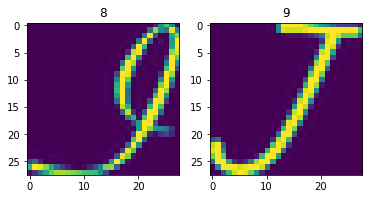

In [29]:
from matplotlib import pyplot as plt

for i in [0,1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [30]:
number_of_classes = len(np.unique(y_train))

In [31]:
# Your turn: create a multiclass classifier in here for notMNIST dataset.
from sklearn.tree import DecisionTreeClassifier

dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 


In [34]:
# create a network that stacks layers on top of each other
from torch import nn
from torch.nn import Sequential
from torch.optim import Adam

model = nn.Sequential()

# add first "dense" layer with 784 input units and 1 output unit. 

model.add_module('l1', nn.Linear(15, 27))
model.add_module('d1', nn.Dropout())
model.add_module('l2', nn.Linear(27, 27))
model.add_module('a3', nn.LogSoftmax(dim=1))

Take a look at the model structure:

In [35]:
import torchsummary

torchsummary.summary(model, (15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 27]             432
           Dropout-2                   [-1, 27]               0
            Linear-3                   [-1, 27]             756
        LogSoftmax-4                   [-1, 27]               0
Total params: 1,188
Trainable params: 1,188
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Let's check that everything works correctly:

In [36]:
import torch

# create dummy data with 3 samples and 784 features
x = torch.tensor(X_train[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted # display what we've got

RuntimeError: size mismatch, m1: [3 x 784], m2: [15 x 27] at /tmp/pip-req-build-4baxydiv/aten/src/TH/generic/THTensorMath.cpp:197

Let's call the loss function from `torch.nn`.

In [ ]:
loss_function = nn.CrossEntropyLoss()

Define some optimizer for your model parameters:

In [ ]:
opt = # YOUR CODE HERE

Compute the loss for some batch of objects:

In [ ]:
loss = # YOUR CODE HERE

Do a backward pass and optimizator step:

In [ ]:
# YOUR CODE HERE

Finally, implement the optimization pipeline and monitor the model quality during the optimization.

In [ ]:
# YOUR CODE HERE